In [1]:
import pandas as pd
import numpy as np
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Flatten, ConvLSTM2D, Dropout
import tensorflow.keras.backend as K

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [2]:
n_steps = 8 # we use 12h window
n_lookup = 1 # predict series of 4 values in time t1, t2, t3, t4

In [3]:
df_train = pd.read_csv("../input/tabular-playground-series-jul-2021/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-jul-2021/test.csv")
df_sub = pd.read_csv("../input/tabular-playground-series-jul-2021/sample_submission.csv")

print(df_test.shape)
print(df_sub.shape)

features = ['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
targets_values = np.log1p(df_train[targets]).values


df_test = pd.concat([df_train[len(df_train)-n_steps-1:len(df_train)-1].drop(targets , axis = 1), df_test])

df_all = pd.concat([df_train.drop(targets , axis = 1), df_test])

df_all['date_time'] = pd.to_datetime(df_all['date_time'])


df_train.set_index('date_time', inplace=True)
df_test.set_index('date_time', inplace=True)
print(df_test.shape)
print(df_all.shape)

(2247, 9)
(2247, 4)
(2255, 8)
(9366, 9)


In [4]:
df_test.head(15)

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
date_time,,,,,,,,
2010-12-31 16:00:00,12.4,25.6,0.4185,926.2,746.4,843.5,974.4,769.6
2010-12-31 17:00:00,12.1,29.3,0.4148,1000.5,883.0,834.4,926.3,913.9
2010-12-31 18:00:00,10.2,32.0,0.4112,922.7,800.7,856.5,876.1,819.8
2010-12-31 19:00:00,9.1,34.3,0.3958,957.9,741.9,970.3,915.1,866.0
2010-12-31 20:00:00,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5
2010-12-31 21:00:00,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4
2010-12-31 22:00:00,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1
2010-12-31 23:00:00,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3
2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1


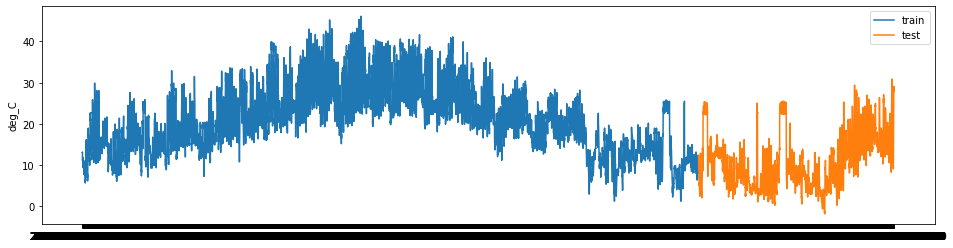

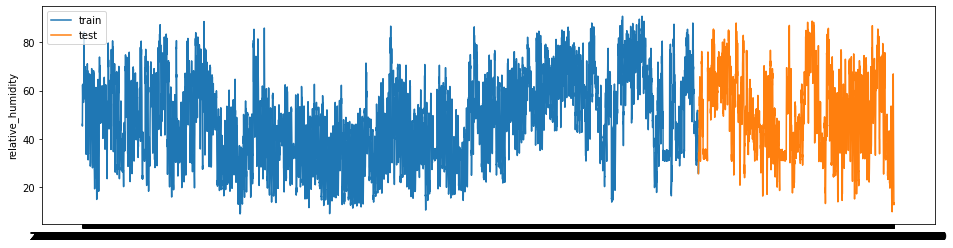

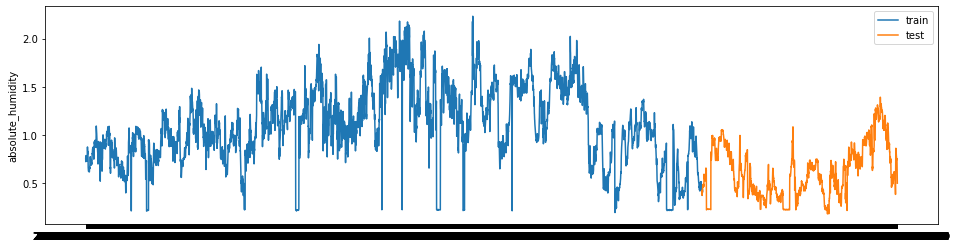

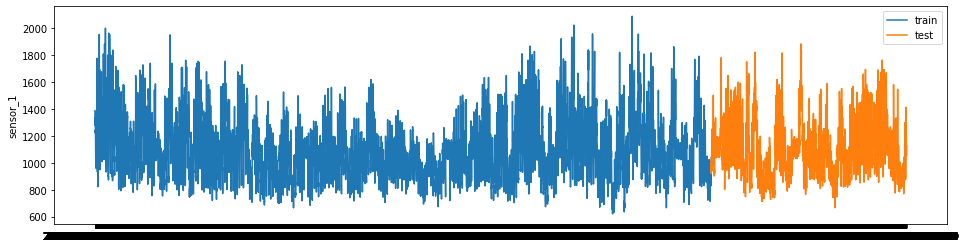

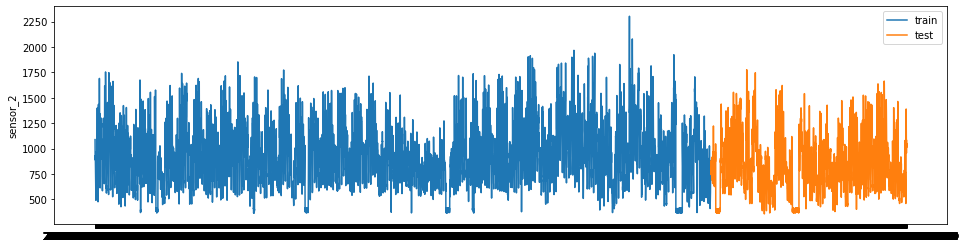

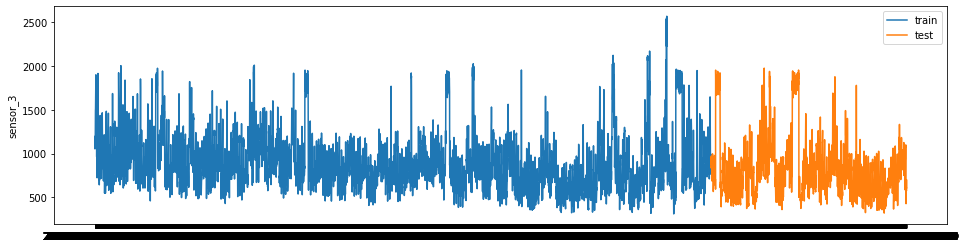

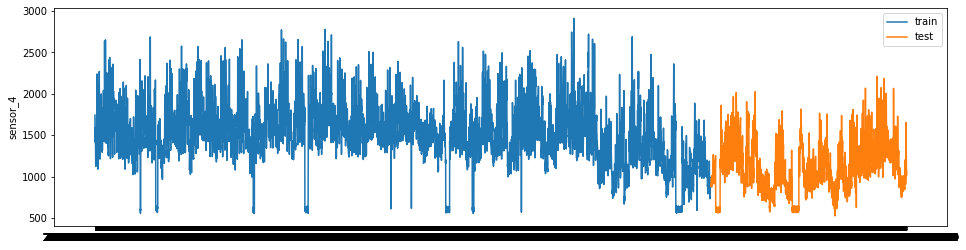

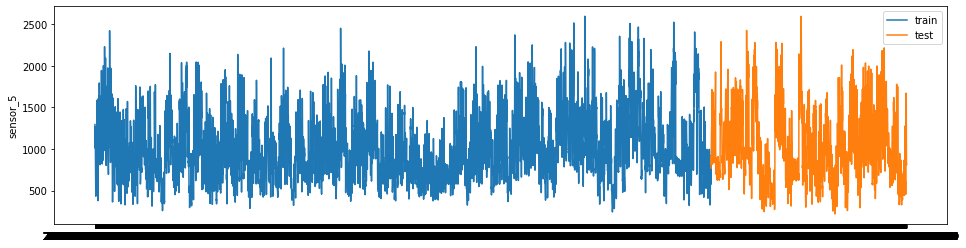

In [5]:
def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(df_train.index, df_train[name], label='train')
    plt.plot(df_test.index, df_test[name], label='test')
    plt.ylabel(name)
    plt.legend()
    plt.show()

for col in df_train[features].columns:
    plot_sensor(col)

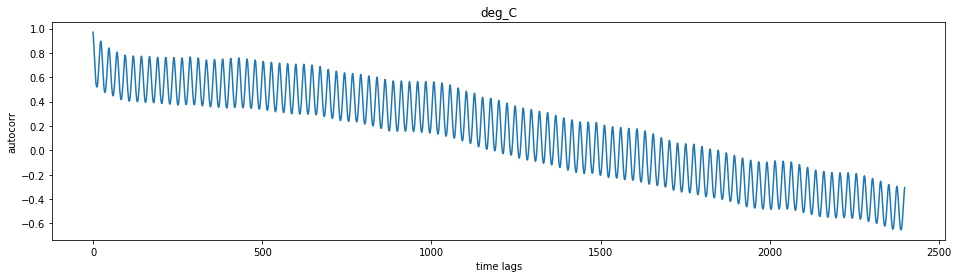

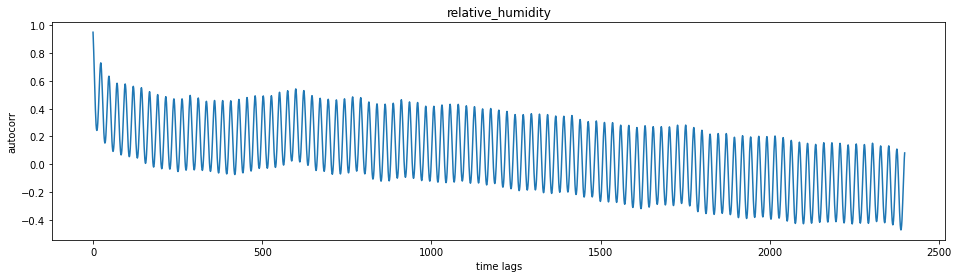

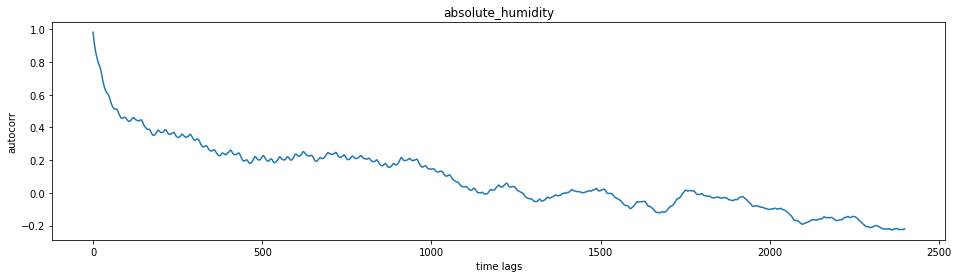

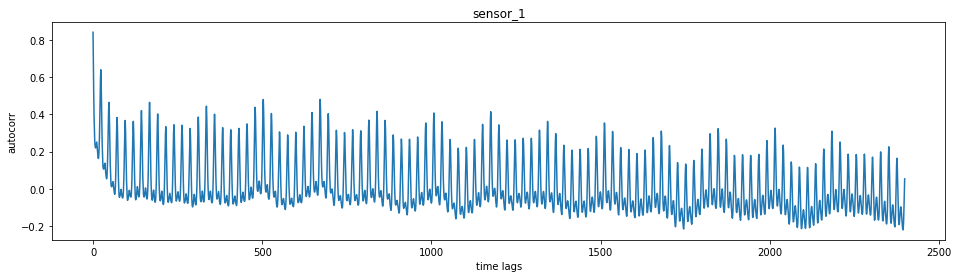

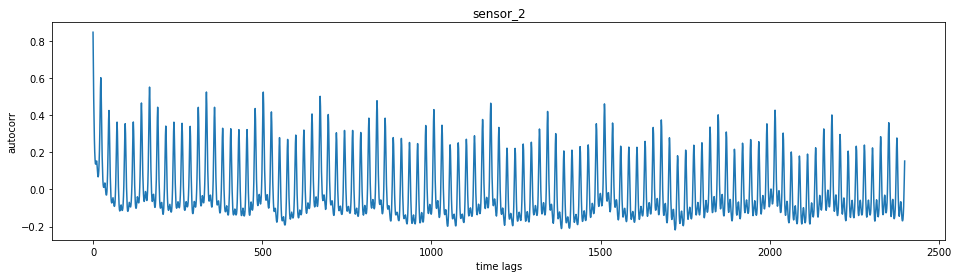

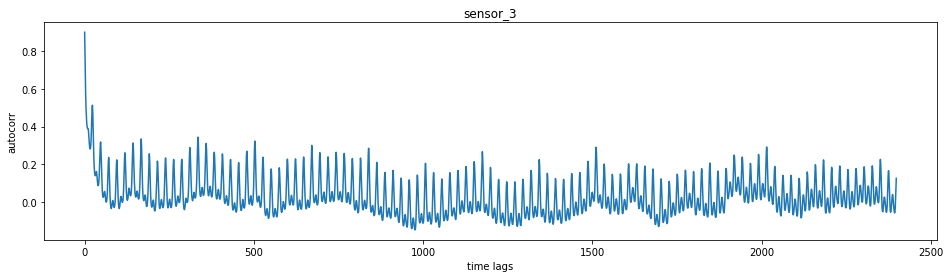

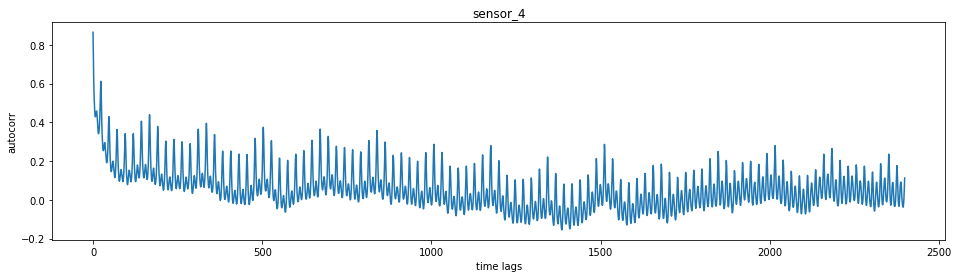

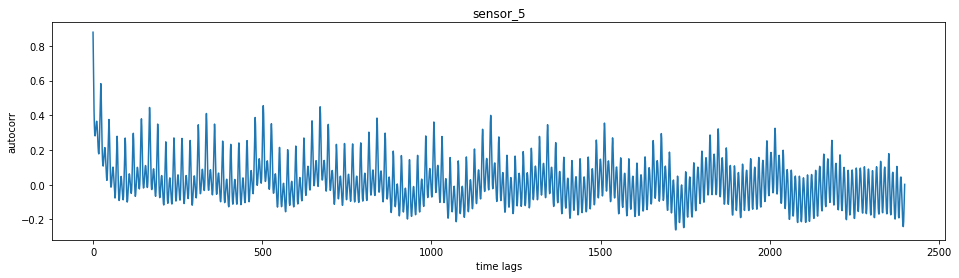

In [6]:
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))    
    timeLags = np.arange(1,2400)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

for col in df_train[features].columns:
    plot_autocor(col, df_train)

### NEW FEATURES

In [7]:
def cycle_sin_cos_coder(data, cols):
    for col in cols:
        data[col + '_s'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_c'] = np.cos(2 * np.pi * data[col]/data[col].max())
    return data

In [8]:
df_all['month'] = df_all['date_time'].dt.month
df_all['day'] = df_all['date_time'].dt.day
df_all['hour'] = df_all['date_time'].dt.hour

df_all = cycle_sin_cos_coder(df_all, ['month','day','hour'])
df_all.drop(['month','day','hour'], axis=1, inplace=True)
df_all.set_index('date_time', inplace=True)

print(df_all.shape)

(9366, 14)


In [9]:
df_all.head(5)

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month_s,month_c,day_s,day_c,hour_s,hour_c
date_time,,,,,,,,,,,,,,
2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,1.0,6.123234e-17,0.897805,-0.440394,-0.979084,0.203456
2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,1.0,6.123234e-17,0.897805,-0.440394,-0.887885,0.460065
2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,1.0,6.123234e-17,0.897805,-0.440394,-0.730836,0.682553
2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,1.0,6.123234e-17,0.897805,-0.440394,-0.519584,0.854419
2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.0,6.123234e-17,0.897805,-0.440394,-0.269797,0.962917


In [10]:
df_train = df_all[:len(df_train)]

df_train [targets] = targets_values
df_test = df_all[len(df_train):]

In [11]:
df_train

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month_s,month_c,day_s,day_c,hour_s,hour_c,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
date_time,,,,,,,,,,,,,,,,,
2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,1.000000e+00,6.123234e-17,8.978045e-01,-0.440394,-9.790841e-01,0.203456,1.252763,2.564949,5.128122
2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,1.000000e+00,6.123234e-17,8.978045e-01,-0.440394,-8.878852e-01,0.460065,1.131402,2.388763,4.604170
2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,1.000000e+00,6.123234e-17,8.978045e-01,-0.440394,-7.308360e-01,0.682553,1.163151,2.322388,4.852811
2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,1.000000e+00,6.123234e-17,8.978045e-01,-0.440394,-5.195840e-01,0.854419,1.163151,2.370244,5.182907
2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.000000e+00,6.123234e-17,8.978045e-01,-0.440394,-2.697968e-01,0.962917,0.916291,2.001480,4.810557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-31 20:00:00,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,-7.308360e-01,0.682553,0.832909,1.808289,5.258016
2010-12-31 21:00:00,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,-5.195840e-01,0.854419,0.875469,1.916923,5.404028
2010-12-31 22:00:00,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,-2.697968e-01,0.962917,0.955511,1.824549,5.431098


In [12]:
train, test = train_test_split(df_train, shuffle = False, train_size=0.8)

### FEATURE TRANSFORMATION

In [13]:
for i in train[features].columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    
    s_train = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_test = scaler.transform(test[i].values.reshape(-1,1))
    s_df_test = scaler.transform(df_test[i].values.reshape(-1,1))
    
    s_train = np.reshape(s_train,len(s_train))
    s_test = np.reshape(s_test,len(s_test))
    s_df_test = np.reshape(s_df_test,len(s_df_test))

    train[i] = s_train
    test[i] = s_test
    df_test[i] = s_df_test

In [14]:
train.head(n_steps+1)

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month_s,month_c,day_s,day_c,hour_s,hour_c,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
date_time,,,,,,,,,,,,,,,,,
2010-03-10 18:00:00,-0.633663,-0.069009,-0.460494,0.063670,-0.096887,-0.138979,0.008005,-0.113612,1.0,6.123234e-17,0.897805,-0.440394,-9.790841e-01,0.203456,1.252763,2.564949,5.128122
2010-03-10 19:00:00,-0.628713,-0.086575,-0.492515,-0.095652,-0.345935,0.027326,-0.240120,-0.355385,1.0,6.123234e-17,0.897805,-0.440394,-8.878852e-01,0.460065,1.131402,2.388763,4.604170
2010-03-10 20:00:00,-0.658416,0.186951,-0.468028,-0.017833,-0.294279,-0.134042,-0.124741,-0.264581,1.0,6.123234e-17,0.897805,-0.440394,-7.308360e-01,0.682553,1.163151,2.322388,4.852811
2010-03-10 21:00:00,-0.737624,0.342535,-0.431843,-0.033898,-0.295028,-0.083857,-0.166758,-0.139458,1.0,6.123234e-17,0.897805,-0.440394,-5.195840e-01,0.854419,1.163151,2.370244,5.182907
2010-03-10 22:00:00,-0.693069,0.257215,-0.429761,-0.106116,-0.390230,0.007816,-0.269262,-0.251573,1.0,6.123234e-17,0.897805,-0.440394,-2.697968e-01,0.962917,0.916291,2.001480,4.810557
2010-03-10 23:00:00,-0.727723,0.202008,-0.433727,-0.181430,-0.583879,0.285538,-0.229362,-0.408362,1.0,6.123234e-17,0.897805,-0.440394,-2.449294e-16,1.000000,0.788457,1.686399,4.489759
2010-03-11 00:00:00,-0.752475,0.174404,-0.458015,-0.147089,-0.619065,0.372510,-0.271380,-0.561898,1.0,6.123234e-17,0.790776,-0.612106,0.000000e+00,1.000000,0.788457,1.547563,4.102643
2010-03-11 01:00:00,-0.772277,0.207026,-0.448201,-0.239646,-0.665980,0.395898,-0.316532,-0.608284,1.0,6.123234e-17,0.790776,-0.612106,2.697968e-01,0.962917,0.693147,1.481605,4.172848
2010-03-11 02:00:00,-0.782178,0.350063,-0.453554,-0.271776,-0.701915,0.512840,-0.441484,-0.658094,1.0,6.123234e-17,0.790776,-0.612106,5.195840e-01,0.854419,0.641854,1.163151,3.858622


## SLIDING WINDOW 

This function split data using SLIDING WINDOW approach:
- n_steps - this is number of steps we want to look into to predict output (one y or series of y)
- n_lookup - number of steps to predict 

In [15]:
def split_sequences(Xsequences, ysequences, n_steps = 6, n_out = 1):
    X, y = list(), list()

    for i in range(len(Xsequences)):
        end_index = i + n_steps
        out_end_index = end_index + n_out
        
        if out_end_index > len(Xsequences):
            break
        
        seq_x = Xsequences.iloc[i : end_index, :] 
        if isinstance(ysequences, pd.core.series.Series):
            seq_y = ysequences.iloc[end_index : out_end_index]
            y.append(seq_y)

        X.append(seq_x)
        
    return array(X), array(y)

In [16]:
Xtrain_seq_tcm, ytrain_seq_tcm = split_sequences(train.drop(targets, axis = 1), train['target_carbon_monoxide'], n_steps, n_lookup)
Xtest_seq_tcm, ytest_seq_tcm = split_sequences(test.drop(targets, axis = 1), test['target_carbon_monoxide'], n_steps, n_lookup)

Xtrain_seq_tb, ytrain_seq_tb = split_sequences(train.drop(targets, axis = 1), train['target_benzene'], n_steps, n_lookup)
Xtest_seq_tb, ytest_seq_tb = split_sequences(test.drop(targets, axis = 1), test['target_benzene'], n_steps, n_lookup)

Xtrain_seq_tno, ytrain_seq_tno = split_sequences(train.drop(targets, axis = 1), train['target_nitrogen_oxides'], n_steps, n_lookup)
Xtest_seq_tno, ytest_seq_tno = split_sequences(test.drop(targets, axis = 1), test['target_nitrogen_oxides'], n_steps, n_lookup)

n_features = Xtrain_seq_tcm.shape[2]

print(Xtrain_seq_tcm.shape, ytrain_seq_tcm.shape)
print(Xtest_seq_tcm.shape, ytest_seq_tcm.shape)

(5680, 8, 14) (5680, 1)
(1415, 8, 14) (1415, 1)


In [17]:
np.set_printoptions(suppress=True, linewidth=255)

Xtest_sub, _ = split_sequences(df_test, [], n_steps, n_lookup)
print(Xtest_sub[0])
print(Xtest_sub.shape)

[[-0.66831683 -0.58092848 -0.79686725 -0.61577008 -0.52286481 -0.38872892 -0.64293278 -0.56189824 -0.          1.         -0.          1.         -0.94226092 -0.33487961]
 [-0.68316832 -0.4880803  -0.80053534 -0.50626382 -0.35242373 -0.39942411 -0.68367995 -0.4384013  -0.          1.         -0.          1.         -0.99766877 -0.06824241]
 [-0.77722772 -0.42032622 -0.80410429 -0.62092852 -0.45511261 -0.37345008 -0.72620611 -0.51893534 -0.          1.         -0.          1.         -0.97908409  0.20345601]
 [-0.83168317 -0.36260979 -0.81937147 -0.56904937 -0.52847963 -0.23970147 -0.69316786 -0.47939578 -0.          1.         -0.          1.         -0.88788522  0.46006504]
 [-0.82673267 -0.42032622 -0.82799643 -0.50626382 -0.44201135 -0.35405771 -0.69833538 -0.44131114 -0.          1.         -0.          1.         -0.73083596  0.68255314]
 [-0.83168317 -0.3902133  -0.83840587 -0.47354458 -0.46846341 -0.2616795  -0.69503156 -0.44738756 -0.          1.         -0.          1.        

In [18]:
np.set_printoptions(suppress=True, linewidth=255)

num_seq_show = 3

for i in range(num_seq_show):
    print(f'X{i}\n {Xtrain_seq_tcm[i]}')
    print(f'y{i}\n {ytrain_seq_tcm[i]} \n\n')

X0
 [[-0.63366337 -0.06900878 -0.4604937   0.06366986 -0.09688689 -0.13897867  0.00800542 -0.11361205  1.          0.          0.89780454 -0.44039415 -0.97908409  0.20345601]
 [-0.62871287 -0.08657465 -0.49251512 -0.09565217 -0.34593549  0.02732562 -0.24012029 -0.35538534  1.          0.          0.89780454 -0.44039415 -0.88788522  0.46006504]
 [-0.65841584  0.18695107 -0.46802816 -0.01783346 -0.29427912 -0.13404243 -0.12474057 -0.26458128  1.          0.          0.89780454 -0.44039415 -0.73083596  0.68255314]
 [-0.73762376  0.3425345  -0.43184297 -0.03389831 -0.29502776 -0.08385732 -0.16675844 -0.13945826  1.          0.          0.89780454 -0.44039415 -0.51958395  0.8544194 ]
 [-0.69306931  0.25721455 -0.42976108 -0.10611643 -0.39023021  0.00781571 -0.26926172 -0.2515726   1.          0.          0.89780454 -0.44039415 -0.26979677  0.96291729]
 [-0.72772277  0.20200753 -0.43372658 -0.18142962 -0.58387922  0.28553799 -0.22936168 -0.4083615   1.          0.          0.89780454 -0.4403

## SIMPLE NN MODEL
We use LSTM (but there is more possibilities to examine). I decided to create Endocer-Decoder (RepeatVector) architecture since we are able to predict more steps in future.

In [19]:
def rmsle(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

### A. LSTM -> Encoder-Decoder -> LSTM -> Dense

In [20]:
model_tcm = Sequential()
model_tcm.add(LSTM(100, activation='tanh', input_shape=(n_steps, n_features)))
model_tcm.add(RepeatVector(n_lookup))
model_tcm.add(LSTM(100, activation='tanh', return_sequences=True))
model_tcm.add(TimeDistributed(Dense(1)))
model_tcm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)

model_tcm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               46000     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              101       
Total params: 126,501
Trainable params: 126,501
Non-trainable params: 0
_________________________________________________________________


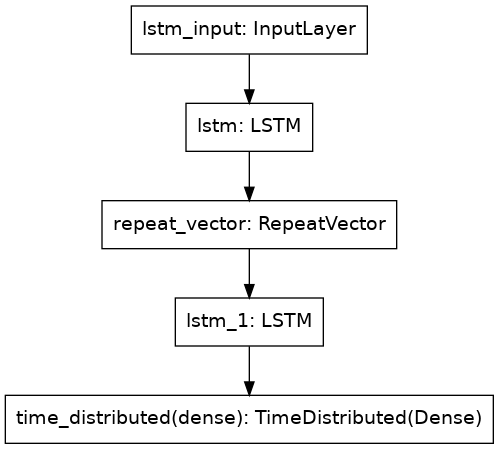

In [21]:
tf.keras.utils.plot_model(model_tcm)

In [22]:
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
red_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

def plot_model_learning(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [23]:
N_SAMPLE = 20
yhat_tcm = np.zeros((Xtest_sub.shape[0],1))

for samples in tqdm(range(N_SAMPLE)):
    tf.keras.backend.clear_session()
    
    model_tcm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)
    history_tcm = model_tcm.fit(Xtrain_seq_tcm, ytrain_seq_tcm, 
                                validation_data = (Xtest_seq_tcm, ytest_seq_tcm), 
                                epochs=100, 
                                verbose = 0,
                                batch_size = 16, 
                                callbacks=[es, red_lr])
    
  
    yhat_tcm += np.expm1(model_tcm.predict(Xtest_sub)).reshape(-1,1)

yhat_tcm = yhat_tcm / N_SAMPLE

  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
yhat_tcm

array([[1.47627977],
       [1.62364682],
       [2.10836962],
       ...,
       [2.17995341],
       [2.26741863],
       [1.92893147]])

### B. ConvLSTM2D -> Encoder-Decoder -> LSTM -> Dense

In [25]:
n_sub_steps = 4
n_length = 2

model_tb = Sequential()
model_tb.add(ConvLSTM2D(64, (1,2), activation='relu', input_shape=(n_sub_steps, 1, n_length, n_features)))
model_tb.add(Flatten())
model_tb.add(RepeatVector(n_lookup))
model_tb.add(LSTM(200, activation='relu', return_sequences=True))
model_tb.add(TimeDistributed(Dense(100, activation='relu')))
model_tb.add(TimeDistributed(Dense(1)))

model_tb.compile(loss='mse', optimizer='adam')

model_tb.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 1, 64)          40192     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 200)            212000    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 100)            20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              101       
Total params: 272,393
Trainable params: 272,393
Non-trainable params: 0
__________________________________________________

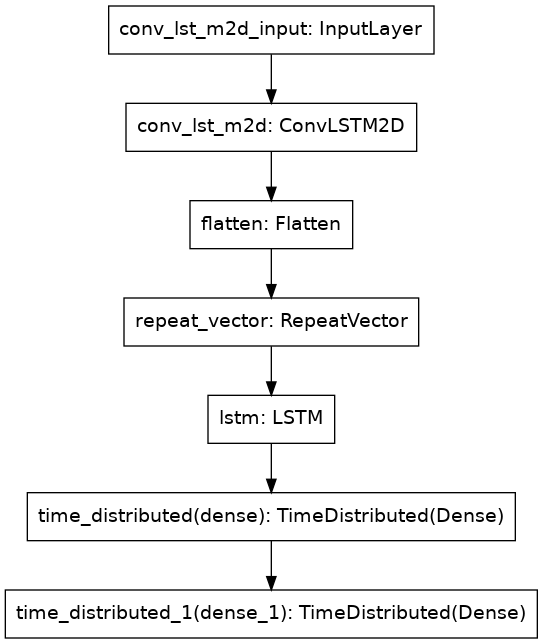

In [26]:
tf.keras.utils.plot_model(model_tb)

In [27]:
Xtrain_seq_tb = Xtrain_seq_tb.reshape((Xtrain_seq_tb.shape[0], n_sub_steps, 1, n_length, n_features))
Xtest_seq_tb = Xtest_seq_tb.reshape((Xtest_seq_tb.shape[0], n_sub_steps , 1, n_length, n_features))

In [28]:
N_SAMPLE = 20
yhat_tb = np.zeros((Xtest_sub.shape[0],1))

for samples in tqdm(range(N_SAMPLE)):
    tf.keras.backend.clear_session()
    
    model_tb.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)
    history_tb = model_tb.fit(Xtrain_seq_tb, ytrain_seq_tb, 
                          validation_data = (Xtest_seq_tb, ytest_seq_tb), 
                          epochs=100,  
                          batch_size = 16, 
                          verbose = 0, 
                          callbacks=[es, red_lr])
  
    yhat_tb += np.expm1(model_tb.predict(Xtest_sub.reshape(Xtest_sub.shape[0], n_sub_steps, 1, n_length, n_features))).reshape(-1,1)

yhat_tb = yhat_tb / N_SAMPLE

  0%|          | 0/20 [00:00<?, ?it/s]

### CONV1D -> Encoder-Decoder -> LSTM -> Dense

In [29]:
model_tno = Sequential()
model_tno.add(Conv1D(64, 3, activation='relu', input_shape=(n_steps, n_features)))
model_tno.add(Conv1D(64, 3, activation='relu'))
model_tno.add(MaxPooling1D())
model_tno.add(Flatten())
model_tno.add(RepeatVector(n_lookup))
model_tno.add(LSTM(100, activation='relu', return_sequences=True))
model_tno.add(TimeDistributed(Dense(64, activation='relu')))
model_tno.add(TimeDistributed(Dense(1)))

model_tno.compile(loss='mse', optimizer='adam')

model_tno.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 64)             2752      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 64)             12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 100)            91600     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 64)             6

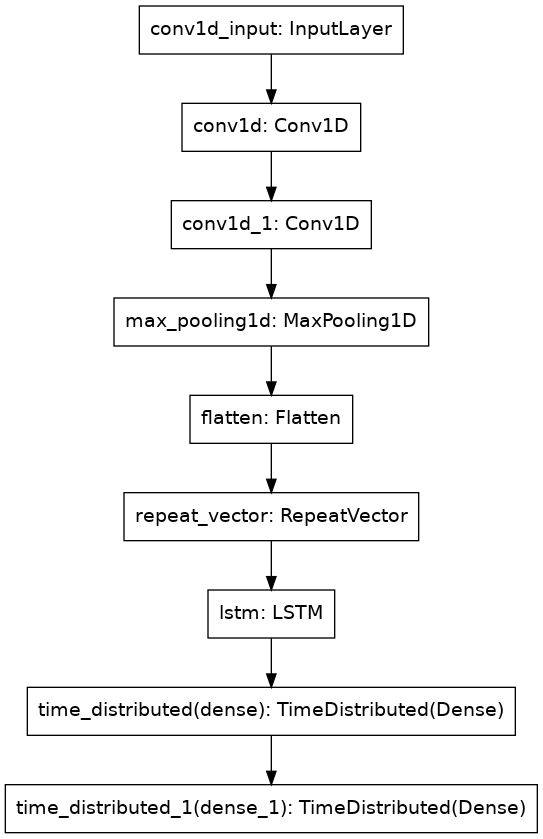

In [30]:
tf.keras.utils.plot_model(model_tno)

In [31]:
N_SAMPLE = 20
yhat_tno = np.zeros((Xtest_sub.shape[0],1))

for samples in tqdm(range(N_SAMPLE)):
    tf.keras.backend.clear_session()
    
    model_tno.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)
    history_tno = model_tno.fit(Xtrain_seq_tno, ytrain_seq_tno, 
                            validation_data = (Xtest_seq_tno, ytest_seq_tno), 
                            epochs=100, 
                            verbose = 1, 
                            batch_size = 16, 
                            callbacks=[es, red_lr])
    
  
    yhat_tno += np.expm1(model_tno.predict(Xtest_sub)).reshape(-1,1)

yhat_tno = yhat_tno / N_SAMPLE

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/100
355/355 [==============================] - 3s 4ms/step - loss: 0.3357 - val_loss: 0.1080
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 0.0789 - val_loss: 0.0891
Epoch 3/100
355/355 [==============================] - 1s 4ms/step - loss: 0.0702 - val_loss: 0.0875
Epoch 4/100
355/355 [==============================] - 1s 4ms/step - loss: 0.0666 - val_loss: 0.0893
Epoch 5/100
355/355 [==============================] - 1s 4ms/step - loss: 0.0637 - val_loss: 0.0808
Epoch 6/100
355/355 [==============================] - 1s 4ms/step - loss: 0.0615 - val_loss: 0.1042
Epoch 7/100
355/355 [==============================] - 2s 5ms/step - loss: 0.0607 - val_loss: 0.0877
Epoch 8/100
355/355 [==============================] - 1s 4ms/step - loss: 0.0588 - val_loss: 0.0985
Epoch 9/100
355/355 [==============================] - 1s 4ms/step - loss: 0.0577 - val_loss: 0.0954
Epoch 10/100
355/355 [==============================] - 1s 4ms/step - loss: 0.0560 - val_lo